In [6]:
# -*- coding: utf-8 -*-
import os
import sys
sys.path.append('/p-antipsychotics-sleep')
import analysis as ana

# Analysis for sleep stage and PSD

/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202/vehicle_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20230501/vehicle_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202/vehicle_24h_before6h/psd_info_list.pkl
/p-antipsychotics-sleep/analyzed/prjCZP-9/20230501/vehicle_24h_before6h/psd_info_list.pkl
/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202/rapalog_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20230501/rapalog_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202/rapalog_24h_before6h/psd_info_list.pkl
/p-antipsychotics-sleep/analyzed/prjCZP-9/20230501/rapalog_24h_before6h/psd_info_list.pkl
                                                               Device label  \
exp_label      mouse_group mouse_ID stage time_in_hour drug                   
EEG_p-iino-1-1 WT          TS074    NREM  0            rapalog          Ch1   
                                   

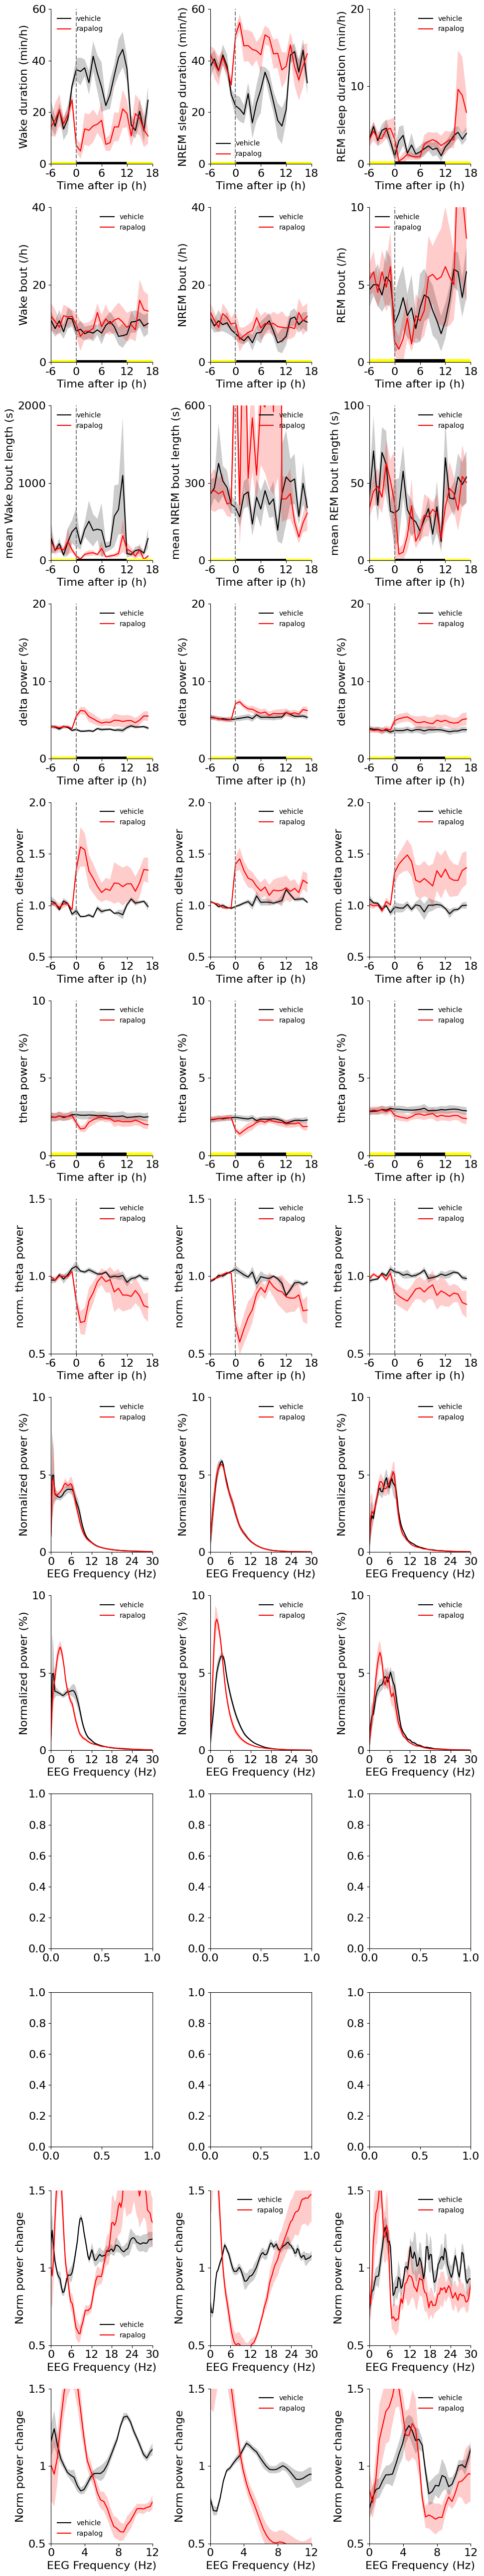

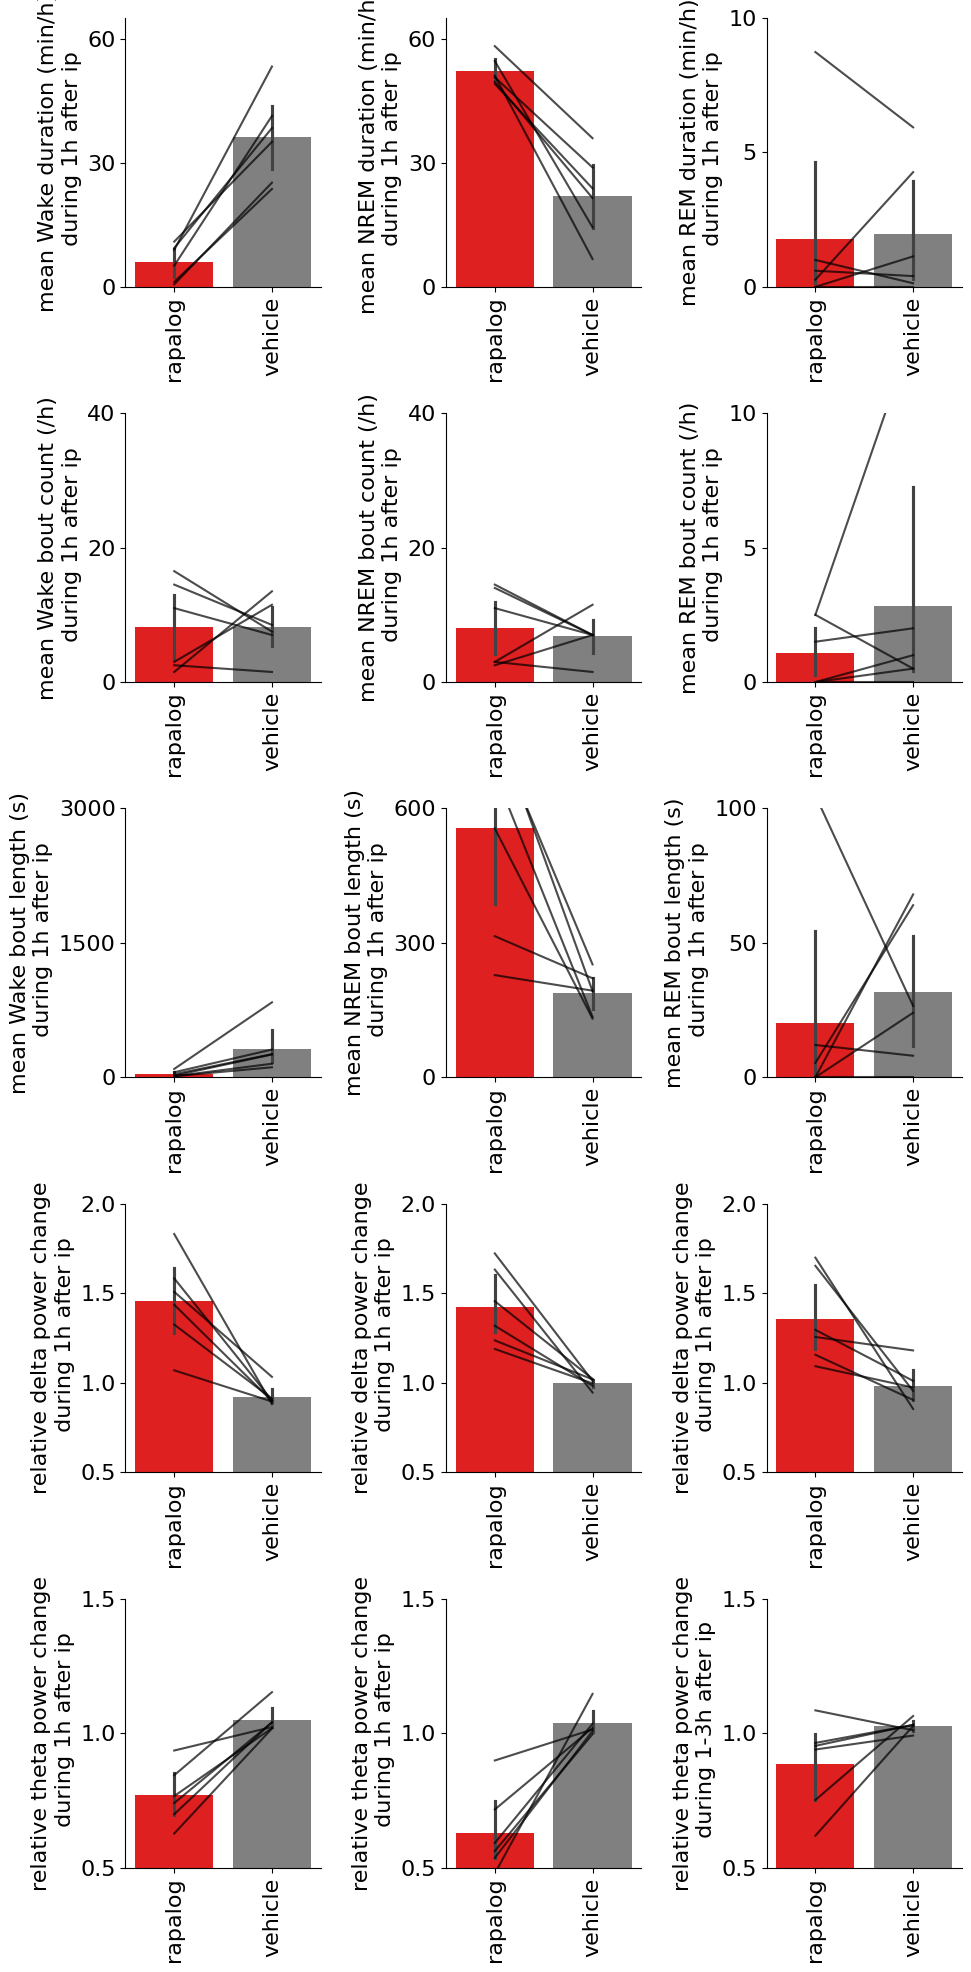

In [18]:
analyzed_dir_list=["/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202","/p-antipsychotics-sleep/analyzed/prjCZP-9/20230501"]
#analyzed_dir_list=["/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202"]

#"/temp/analyzed/prj11/20231230_2" is omitted by abnormal PSD shape

rename_dict = {
    "PFC-in-enlarge": "WT"
    }

exclude_mouse_list=["TS073","TS076"]
target_group="WT"
output_dir="/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-CZP"
os.makedirs(output_dir,exist_ok=True)
epoch_len_sec=8
sample_freq=128
#merge_n_plot(analyzed_dir_list,epoch_len_sec,sample_freq,exclude_mouse_list,target_group,output_dir,group_rename_dic=rename_dict)
test=ana.merge_n_plot(analyzed_dir_list,epoch_len_sec,sample_freq,exclude_mouse_list,target_group,output_dir,group_rename_dic=rename_dict)

In [15]:
import pandas as pd
import analysis as ana

stage_df=pd.read_csv("/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-CZP/meta_stage_n_bout_df_after.csv")
psd_df=pd.read_csv("/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-CZP/merge_norm_psd_ts_df_after.csv")
bout_df=pd.read_csv("/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-CZP/meta_stage_n_bout_df_after.csv")
target_group="WT"
stage="NREM"
ana.wilcoxon_n_paried_t(stage_df,psd_df,bout_df,target_group,stage)

stage="Wake"
ana.wilcoxon_n_paried_t(stage_df,psd_df,bout_df,target_group,stage)

stage="REM"
ana.wilcoxon_n_paried_t(stage_df,psd_df,bout_df,target_group,stage)

NREM
WT
stage duration
wilcoxon
Statistic: 0.0
p-value: 0.03125
paired t test
Statistic: -7.731731972107258
p-value: 0.0005781893403621311
stage bout count
wilcoxon
Statistic: 9.0
p-value: 0.84375
stage bout length
wilcoxon
Statistic: 0.0
p-value: 0.03125
norm delta power
wilcoxon
Statistic: 0.0
p-value: 0.03125
paired t test
Statistic: -4.65206306474024
p-value: 0.005571760691317045
norm theta power
wilcoxon
Statistic: 0.0
p-value: 0.03125
paired t test
Statistic: 5.392264533793258
p-value: 0.00296075143918394
Wake
WT
stage duration
wilcoxon
Statistic: 0.0
p-value: 0.03125
paired t test
Statistic: 8.634309686894165
p-value: 0.0003441055628267691
stage bout count
wilcoxon
Statistic: 10.0
p-value: 1.0
stage bout length
wilcoxon
Statistic: 0.0
p-value: 0.03125
norm delta power
wilcoxon
Statistic: 0.0
p-value: 0.03125
paired t test
Statistic: -5.043025816750227
p-value: 0.003956686767463394
norm theta power
wilcoxon
Statistic: 0.0
p-value: 0.03125
paired t test
Statistic: 6.53711411983968

/usr/local/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric_diff_veh/vehicle_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric_diff_veh/vehicle_24h_before6h/psd_info_list.pkl


/p-antipsychotics-sleep/analysis.py:151: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df=pd.concat([nrem_start_psd_df,nrem_end_psd_df,rem_start_psd_df,rem_end_psd_df,wake_start_psd_df,wake_end_psd_df])


/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric_diff_veh/rapalog_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric_diff_veh/rapalog_24h_before6h/psd_info_list.pkl


/p-antipsychotics-sleep/analysis.py:151: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df=pd.concat([nrem_start_psd_df,nrem_end_psd_df,rem_start_psd_df,rem_end_psd_df,wake_start_psd_df,wake_end_psd_df])


                                                               Device label  \
exp_label      mouse_group mouse_ID stage time_in_hour drug                   
EEG_p-iino-1-1 WT          YI033    NREM  0            rapalog          Ch0   
                                                       vehicle          Ch0   
                                          1            rapalog          Ch0   
                                                       vehicle          Ch0   
                                          2            rapalog          Ch0   
...                                                                     ...   
                           YI036    Wake  21           vehicle          Ch3   
                                          22           rapalog          Ch3   
                                                       vehicle          Ch3   
                                          23           rapalog          Ch3   
                                                    

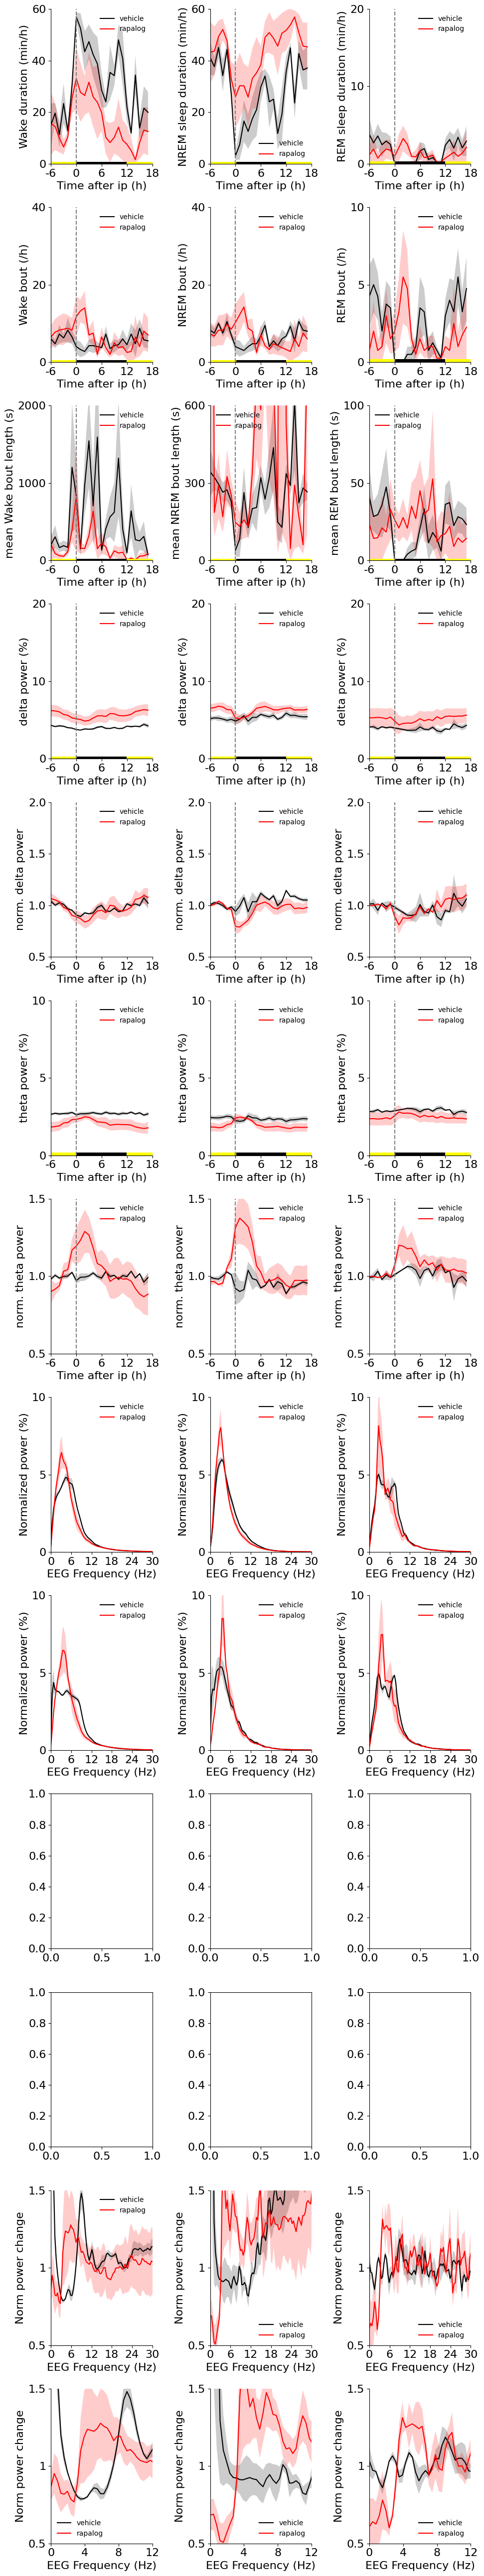

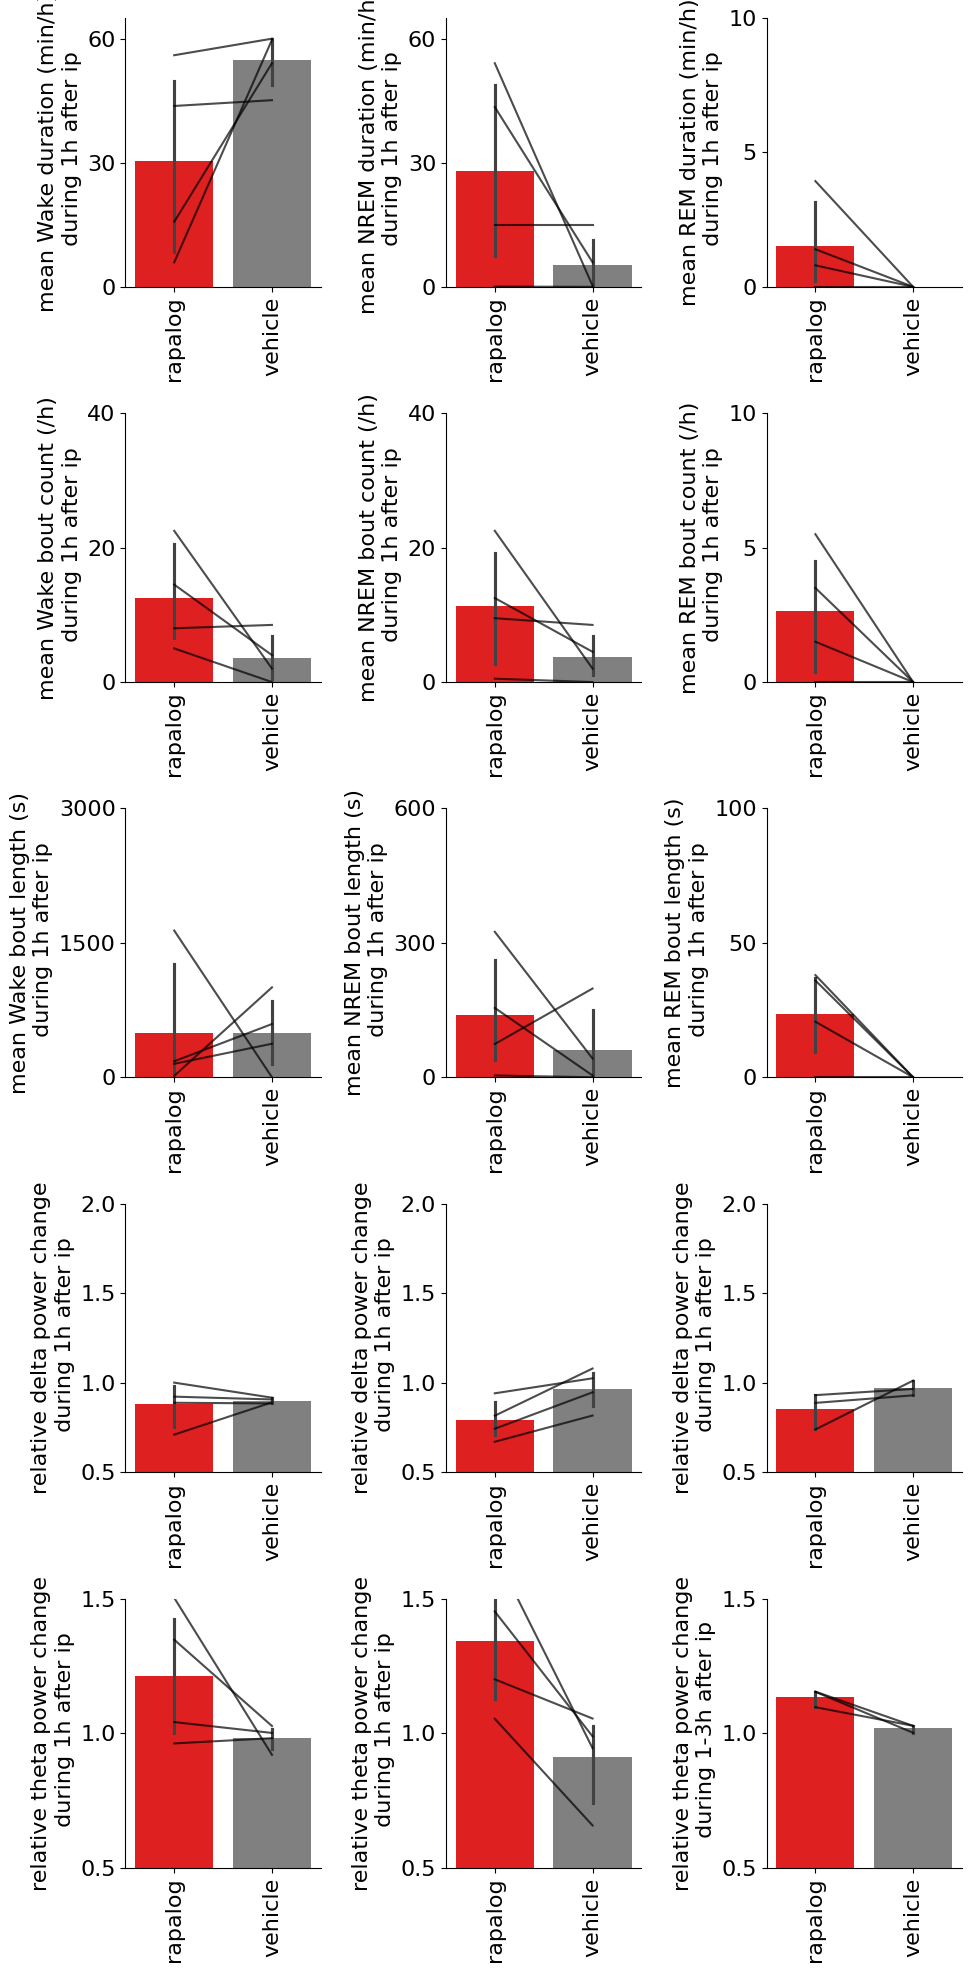

In [16]:
analyzed_dir_list=["/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric_diff_veh"]

#"/temp/analyzed/prj11/20231230_2" is omitted by abnormal PSD shape

rename_dict = {
    "PFC-ex-enlarge-HP-hM4Di": "PFC-ex-enlarge",
    "uniPFC-ex-enlarge": "PFC-ex-enlarge",
    "biPFC-ex-enlarge": "PFC-ex-enlarge",
    "noAAV": "PFC-ex-GFPctrl"
    }

exclude_mouse_list=[]
target_group="WT"
output_dir="/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-muric_diff_veh"
os.makedirs(output_dir,exist_ok=True)
epoch_len_sec=8
sample_freq=128
#merge_n_plot(analyzed_dir_list,epoch_len_sec,sample_freq,exclude_mouse_list,target_group,output_dir,group_rename_dic=rename_dict)
test=ana.merge_n_plot(analyzed_dir_list,epoch_len_sec,sample_freq,exclude_mouse_list,target_group,output_dir,group_rename_dic=rename_dict)

In [5]:
import pandas as pd
import analysis as ana

stage_df=pd.read_csv("/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-muric_diff_veh/meta_stage_n_bout_df_after.csv")
psd_df=pd.read_csv("/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-muric_diff_veh/merge_norm_psd_ts_df_after.csv")
bout_df=pd.read_csv("/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-muric_diff_veh/meta_stage_n_bout_df_after.csv")
target_group="WT"
stage="NREM"
ana.wilcoxon_n_paried_t(stage_df,psd_df,bout_df,target_group,stage)

stage="Wake"
ana.wilcoxon_n_paried_t(stage_df,psd_df,bout_df,target_group,stage)

stage="REM"
ana.wilcoxon_n_paried_t(stage_df,psd_df,bout_df,target_group,stage)

NREM
WT
stage duration
wilcoxon
Statistic: 2.0
p-value: 0.375
paired t test
Statistic: -1.4735448020653579
p-value: 0.2370309079230749
stage bout count
wilcoxon
Statistic: 0.0
p-value: 0.125
stage bout length
wilcoxon
Statistic: 3.0
p-value: 0.625
norm delta power
wilcoxon
Statistic: 1.0
p-value: 0.25
paired t test
Statistic: 2.689562634382489
p-value: 0.07444178191722521
norm theta power
wilcoxon
Statistic: 0.0
p-value: 0.125
paired t test
Statistic: -2.1806780827541474
p-value: 0.11727442919214172
Wake
WT
stage duration
wilcoxon
Statistic: 2.0
p-value: 0.375
paired t test
Statistic: 1.6493051013221165
p-value: 0.19764683419981569
stage bout count
wilcoxon
Statistic: 0.0
p-value: 0.10880943004054568
stage bout length
wilcoxon
Statistic: 3.0
p-value: 0.625
norm delta power
wilcoxon
Statistic: 5.0
p-value: 1.0
paired t test
Statistic: 0.6138563750982319
p-value: 0.58272136843898
norm theta power
wilcoxon
Statistic: 0.0
p-value: 0.125
paired t test
Statistic: -1.7793128644380942
p-value:

/usr/local/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
